现在一提到文本分析，除了词频统计、情感分析，就属话题分析最火，主流技术路线是使用LDA话题模型进行主题分析。但是LDA适合文档区分度大，文本档数较大。如果不满足这两点，LDA虽然能跑出模型，但是跑出的topic无法解读，没有意义。今天在阅读Python技术实现文之前，将技术文的背景文献稍微整理翻译了下，方便大家更好的理解文本网络分析的应用场景。

## 背景-文化桥梁
文化信息传递理论和公共审议和计算技术。
>Markowitz, D. M., & Shulman, H. C. (2021). The predictive utility of word familiarity for online engagements and funding. Proceedings of the National Academy of Sciences, 118(18).

由于每天光顾此类论坛的人数迅速增加，社交媒体为倡导组织塑造公共辩论提供了有力的机会。 然而，社会科学家还没有解释为什么一些**议题发起者**能成功发起大规模的广泛参与性(公开辩论/广泛对话)，而大多数其他组织却没做到。 本文使用自动文本分析发现，如果组织方建立**文化桥梁**，在很少能一起讨论的议题领域内产生可连接的对话主题信息，这类信息不仅能引起多个受众的共鸣，而且还能让这些受众彼此进行对话，那么组织方更有可能激发新社交媒体受众的评论。
在控制这些因素的情况下，建立实质性文化桥梁的组织， 其所发布信息， 比那些没有建立实质性文化桥梁的组织， 得到的评论数多 2.52 倍。

![](img/large.jpg)

社交网络分析通常用于描述个人之间的友谊或其他关系，但它也可通过参与者的消息或想法的类型来描述参与者之间的关系（如下图) 是“文化网络”中的一个小区域。 
- 每个节点描述一个参与议题公开对话的参与者
- 节点间的边代表那些在社交媒体倡导领域内讨论类似议题的人。 


PNAS2016这篇使用“**自闭症谱系障碍ASD疾病的治病原因大讨论**”做的数据分享，图中 t1 处的一类用户认为ASD致病可能跟疫苗有关，而另一类人可能认为ASD可能与遗传因素的有关。从图形看，t1这类议题发起方式，没有产生广泛参与性。而t2和t3，文化网络中因为文化桥梁的存在，产生了广泛参与性。

**假设的文化网络**，其中节点代表参与有关议题的对话参与者，而节点之间的边则描述了其消息内容的相似性。议题广泛参与性，除了话题发起者影响力、话题投放资源等因素影响，还有一个因素就是发起的话题是否吸引了受众。对于参与者而言，最有吸引力的话题需要满足**“新颖，且熟悉”**。

### 用TF-IDF刻画文化网络中的“新且熟悉”
在文本分析中有一个文本特征提取技术tf-idf
- tf指词语在某文档中出现的次数；从词语的角度，该值越大越熟悉
- idf逆文档数，即词语出现在多少个文档中；从词语的角度，该值越小越新颖

![](img/large2.jpg)


本教程将引导您完成使用文本网络分析和可视化数据所需的所有步骤。 在解决与使用文本网络相关的其他杂项问题之前，本教程首先介绍了一个独立的示例。



<br>

## 1. 查看数据
pnas2016这篇的数据没有开源，通过文本构建文化网络、发现文化桥梁。​这里使用一个特别特别小的新闻数据，关于人类第一次登月。如果我们使用textnets，准备的数据需要有两个列
- 议题参与者，类比报刊
- 议题参与者发布的内容，如评论等

In [ ]:
import pandas as pd

df = pd.read_csv('test.csv')
df

```
|    | Unnamed: 0        | headlines                                                                 |
|---:|:------------------|:--------------------------------------------------------------------------|
|  0 | The Guardian      | 3:56 am: Man Steps On to the Moon                                         |
|  1 | New York Times    | Men Walk on Moon -- Astronauts Land on Plain, Collect Rocks, Plant Flag   |
|  2 | Boston Globe      | Man Walks on Moon                                                         |
|  3 | Houston Chronicle | Armstrong and Aldrich "Take One Small Step for Man" on the Moon           |
|  4 | Washington Post   | The Eagle Has Landed -- Two Men Walk on the Moon                          |
|  5 | Chicago Tribune   | Giant Leap for Mankind -- Armstrong Takes 1st Step on Moon                |
|  6 | Los Angeles Times | Walk on Moon -- That\'s One Small Step for Man, One Giant Leap for Mankind |
```

<br>

## 2. 导入corpus
使用textnets库的将数据导入为其特有的语料格式。从下方可以看到textnets可能会用spacy，如果要配置英文en_core_web_sm或中文zh_core_web_sm, 请查看该文 https://t.hk.uy/aCmr

In [ ]:
import textnets as tn
import pandas as pd
#设置随机种子，保证代码可重复性
tn.params["seed"] = 42

corpus = tn.Corpus.from_csv('test.csv')
corpus

![](img/corpus.png)

<br>

## 3. 构建网络
需要注意的是corpus.tokenized()是textnets特有的分词方法，如果所处理的新闻是中文，需要提前分词去停用词整理为像英文数据格式，用空格间隔单词。

textnets提供了构建网络的方法 

tn.Textnet(data, min_docs, connected, doc_attrs)
- data DataFrame类型, 三列，自己可以运行 corpus.tokenized() 查看样式
- min_docs 一个词语存在于至少多少个文档中，默认为2。一个词至少出现在两个doc中，才会让两个doc产生连接
- connected 仅保留网络的最大连接组件（默认值：False）
- doc_attrs 文档节点的属性，字典的字典(双层嵌套字典)

In [68]:
t = tn.Textnet(corpus.tokenized(), min_docs=1)

使用所有默认参数， textnets 会帮我们删除英文停用词，词干化(合并同类词)，并删除标点符号、数字、URL 等。 

但这里我们将破例将 min_docs 设置为1（因为数据只有几句话几十个单词，这里破例设置为1，正常这里至少是2）

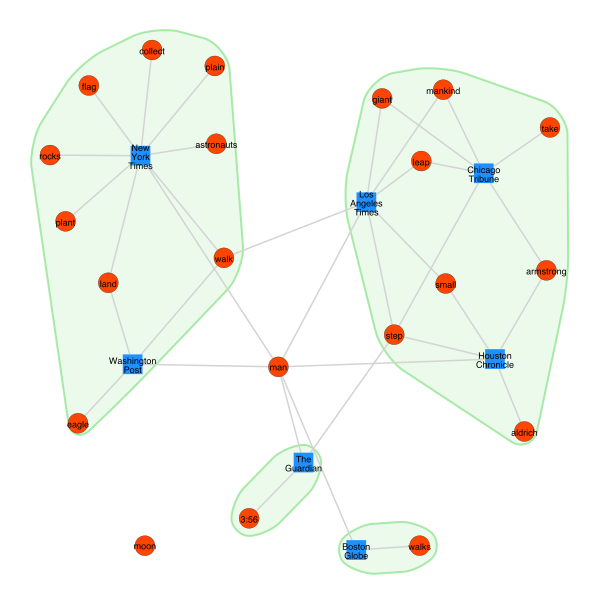

In [75]:
t.plot(label_nodes=True,   #标记节点名(单词、媒体)
       show_clusters=True) #绘制簇的边界

show_clusters 使用 **Leiden 社区检测算法(Leiden community detection algorithm)**找到了分区成簇，它似乎识别了**同一主题(登月)**下不同词之间的远近(相似的词在一个簇中，不同的词处于不同的簇中)。

你可能会疑惑：为什么网络图中的**单词: moon**会自己漂移？ 那是因为moon这个词在每个文档中只出现一次，所以每个文档moon的tf-idf得分为0。

让我们再次可视化相同的事情，但这次根据节点的 BiRank（二部网络的中心性度量）缩放节点，根据权重缩放边缘。

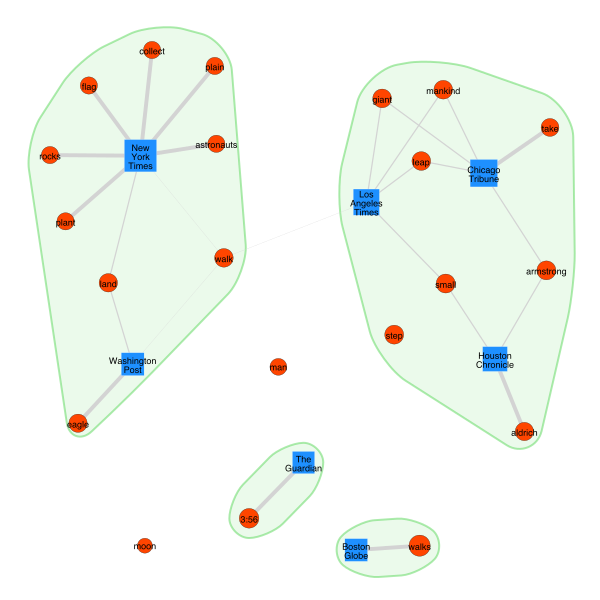

In [76]:
t.plot(label_nodes=True,
       show_clusters=True,
       scale_nodes_by="birank",
       scale_edges_by="weight")

我们还可以只可视化报刊网络，不显示词语。这里设置node_type='doc'

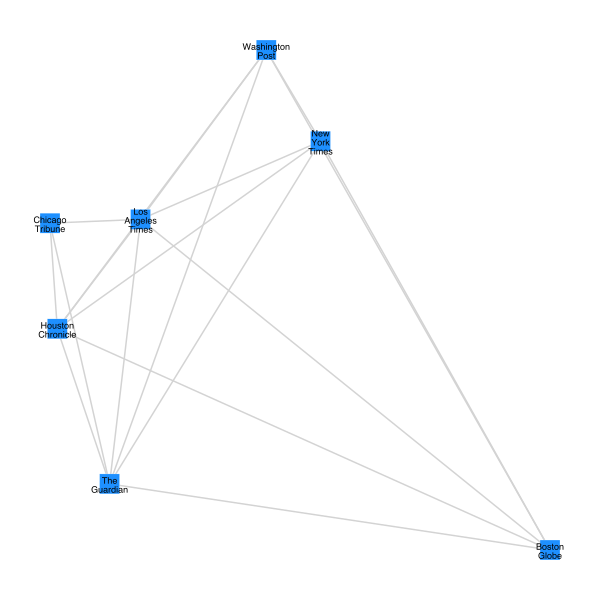

In [80]:
#node_type有两种值， doc、term
papers = t.project(node_type="doc")
papers.plot(label_nodes=True)

和之前的双向网络一样，我们可以看到Houston Chronicle、  Chicago Tribune、  Los Angeles Times更紧密地聚集在一起。

接下来，词网络：

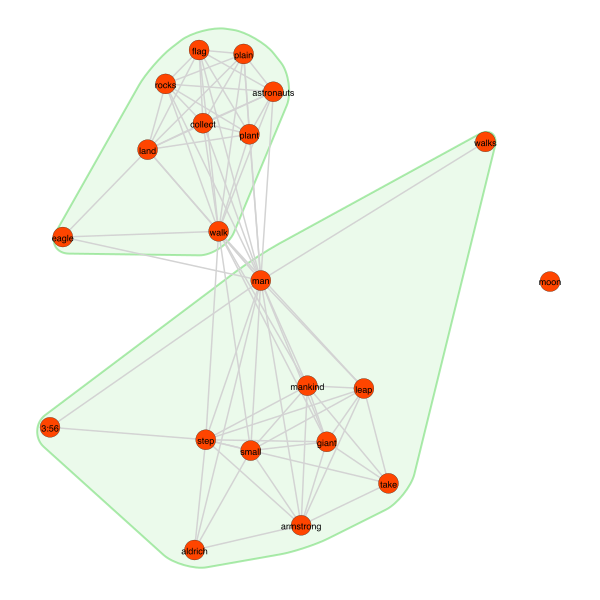

In [81]:
words = t.project(node_type="term")
words.plot(label_nodes=True,
           show_clusters=True)

除了可视化之外，我们还可以使用**社交网络指标**分析我们的语料库。 例如，具有教高**介数中心性betweenness centrality**的文档可能将主题不同簇联系起来，起到文化桥梁的作用，从而刺激跨越符号鸿沟的交流(Bail,2016)。

In [12]:
papers.top_betweenness()

Los Angeles Times    7.0
Boston Globe         0.0
Chicago Tribune      0.0
Houston Chronicle    0.0
New York Times       0.0
The Guardian         0.0
Washington Post      0.0
dtype: float64

In [13]:
words.top_betweenness()

walk         72.00
man          18.00
step         16.00
small        12.75
land          6.00
giant         6.00
leap          6.00
mankind       6.00
armstrong     3.25
plain         0.00
dtype: float64

这是因为New York Times在其标题中使用了“walk”一词，将“one small step”簇与“man on moon”簇联系起来。

我们可以再次生成词网络图，这次根据节点的中介中心性缩放节点，并使用“骨干提取”从网络中修剪边缘：cite:p`Serrano2009`。

我们还可以使用 color_clusters（而不是 show_clusters）根据节点的分区为节点着色。

我们可以过滤节点标签，只标记那些中间中心性betweenness centrality分数高于中位数的节点。 这在高阶网络中特别有用，其中标记每个节点会导致视觉混乱。

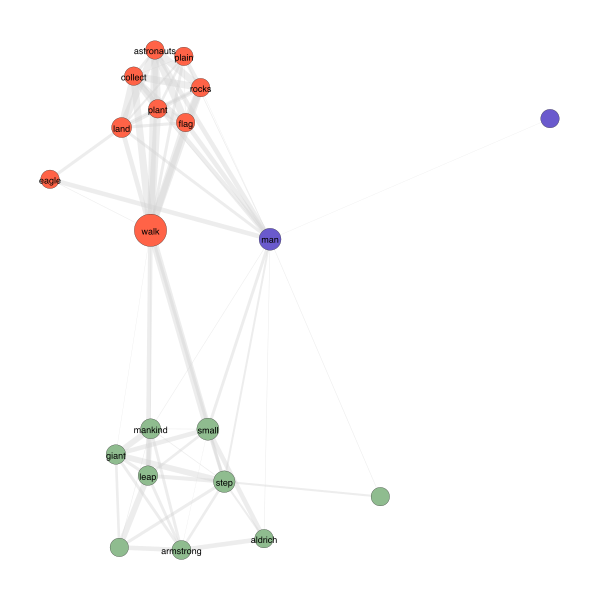

In [82]:
words.plot(label_nodes=True,
           scale_nodes_by="betweenness",
           color_clusters=True,
           alpha=0.5,
           edge_width=[10*w for w in words.edges["weight"]],
           edge_opacity=0.4,
           node_label_filter=lambda n: n.betweenness() > words.betweenness.median())